# Project 2 - Neural Net

Since we've already seen how well a linear classifier works ($\text{F1}_{\text{insincere}} = 62\%$), we can now start trying to improve our score with other models. 

In this notebook we will work with various neural networks.



 ### *NOTE: IT IS __STRONGLY__ RECOMMENDED YOU RUN THIS NOTEBOOK IN A CONTEXT THAT HAS AN AVAILABLE GPU OR TPU*

# Load Data and Import Libraries

Similarly to the baseline, we can import the data to our workbook.




In [1]:
#Import Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, plot_confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from sklearn_pandas import DataFrameMapper
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import SMOTE 
import csv
import random

In [2]:
!pip install tensorflow

In [42]:
4# Code to read csv file from Google Drive into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [54]:
#Load data
def downloadData(id, name):
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(name)  

downloadData('13NWt_psgp8p559FOslMsBKPkZixYPH2b', 'train.tsv')
downloadData('12R3DJeN-4-En2zV5P3DR6h7r1y-Uboad', 'test.tsv')
downloadData('1XOzwsN7KH0R3ju-Ug2TQUd0HEFu2swst', 'dev.tsv')

AttributeError: ignored

In [55]:
columns = [
    "id",
    "label",
    "alpha",
    "text"
]

train = pd.read_csv("train.tsv", names=columns, sep="\t")
dev = pd.read_csv("dev.tsv", names=columns, sep="\t")
test = pd.read_csv("test.tsv", names=columns, sep="\t")

In [48]:
dev

,id,label,alpha,text
0,0,1,a,Where can I find best romantic shayaris?
1,1,0,a,When we check the UPSC rank list; many of the ...
2,2,0,a,Is there is any web site to create search engi...
3,3,0,a,How can you earn $50 just clicking ads?
4,4,0,a,Which 3 branches of engineering have the most ...
...,...,...,...,...
130608,130608,0,a,How can the ViewSonic PA503S 3600 lumens SVGA ...
130609,130609,0,a,What are the biggest myths about Adolf Hitler?
130610,130610,0,a,What song played in the movie of the gifted wh...
130611,130611,0,a,"What do Socrates, Thomas Kuhn and Karl Popper ..."


In [7]:
from imblearn.over_sampling import RandomOverSampler 
rus = RandomOverSampler()
print(len(train))
print(train['label'].shape)
train_os, train_os_lab = rus.fit_resample(train, train.label)
print(len(train_os))
train_os


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


1044897
(1044897,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1960790


array([[0, 0, 'a',
        'What is the most effective classroom management skill/technique to create a good learning environment?'],
       [1, 0, 'a',
        'Can I study abroad after 10th class from Bangladesh?'],
       [2, 0, 'a', 'How can I make friends as a college junior?'],
       ...,
       [480080, 1, 'a',
        'Why do Turkish people insist on letting Europeans listen to their music which sounds pretty ugly and Balkan/Arabic to us?'],
       [270077, 1, 'a',
        'Why do right wingers seem so cruel and callous?'],
       [569174, 1, 'a',
        "Brennan is a traitor to this country. He also is responsible for the theft of Stanley Soetoro Obama's State Dept. passport file in 2008. He had his employees go there and remove anything problematic for Obama. What did he got in return, head of CIA?"]],
      dtype=object)

In [8]:
train_os = pd.DataFrame(train_os, columns=train.columns)
neg, pos = np.bincount(train_os.label)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1960790
    Positive: 980395 (50.00% of total)



In [9]:
train_os

,id,label,alpha,text
0,0,0,a,What is the most effective classroom managemen...
1,1,0,a,Can I study abroad after 10th class from Bangl...
2,2,0,a,How can I make friends as a college junior?
3,3,0,a,How do I download free APK Minecraft: Pocket E...
4,4,0,a,"Like Kuvera, is ""Groww"" also a free online inv..."
...,...,...,...,...
1960785,855355,1,a,If prabhupada says all women loves rape. Then ...
1960786,528152,1,a,Do you believe the increase in filth and homel...
1960787,480080,1,a,Why do Turkish people insist on letting Europe...
1960788,270077,1,a,Why do right wingers seem so cruel and callous?


In [10]:
from nltk.stem.porter import PorterStemmer
import numpy as np
import pandas as pd
import nltk as nltk
import re
import gensim 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTE, RandomOverSampler

class TextObject(pd.DataFrame):
    """
    A collection of strings for processing. Is a DataFrame with specific 
    columns. 
    """

    def __init__(self):
        super().__init__(columns=[
            "original_text",
            "text",
            "label"
        ]
        )
        self._attrs["applied_transformations"] = []
        nltk.download("stopwords")
        nltk.download("punkt")

    def add_text(self, text_collection, labels=None):
        """
        Adds a collection of text to to the TextObject. Accepts an iterable or 
        array-like of all text strings. Optionally, accepts labels of the same 
        length. Modifies self to be a pandas DataFrame with column "text" and 
        potentially "labels".
        """
        self["original_text"] = text_collection
        self["text"] = self.original_text
        self._attrs["applied_transformations"] = []
        if type(labels) == type(None):
            return
        if len(labels) == len(self):
            self["label"] = labels

    # Text Processing Methods:

    def text_processing(self, function):
        """
        Applies a generic text processing function to the self.text field.
        """
        self.text = self.text.apply(function)
        self._attrs["applied_transformations"].append(function.__name__)

    def lower(self):
        self.text = self.text.str.lower()
        self._attrs["applied_transformations"].append("lower")
    
    def strip(self):
        self.text = self.text.str.strip()
        self._attrs["applied_transformations"].append("strip")

    def remove_single_digits(self):
        self.text = self.text.apply(lambda text: re.sub("([\d]+)", "", text))
        self._attrs["applied_transformations"].append("remove_single_digits")
    
    def remove_nonletter_chars(self):
        self.text = self.text.apply(lambda text: re.sub("[^A-Za-z0-9 \\n]", " ", text))
        self._attrs["applied_transformations"].append("remove_nonletter_chars")

    def stop_word_tokenize(self):
        def tokenize(text):
            self.stoplist = nltk.corpus.stopwords.words('english')
            finalTokens = []
            tokens = nltk.word_tokenize(text)
            for w in tokens:
                if (w not in self.stoplist):
                    finalTokens.append(w)
            text = " ".join(finalTokens)
            return text
        self.text = self.text.apply(tokenize)
        self._attrs["applied_transformations"].append("stop_word_tokenize")
    
    def stem_sentence(self):
        def stem(text):
            porter=PorterStemmer()
            token_words=nltk.tokenize.word_tokenize(text)
            token_words
            stem_sentence=[]
            for word in token_words:
                stem_sentence.append(porter.stem(word))
                stem_sentence.append(" ")
            return "".join(stem_sentence)
        self.text = self.text.apply(stem)
        self._attrs["applied_transformations"].append("stem_sentence")

    def lemmatize_sentence(self):
        def lem(text):
            wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
            #token_words
            token_words=nltk.tokenize.word_tokenize(text)
            lemm_sentence=[]
            for word in token_words:
                lemm_sentence.append(wordnet_lemmatizer.lemmatize(word))
                lemm_sentence.append(" ")
            return "".join(lemm_sentence)
        self.text = self.text.apply(lem)
        self._attrs["applied_transformations"].append("lemmatize_sentence")

    def process_all(self, lower=True, strip=True, remove_single_digits =True, 
        remove_nonletter_chars=True, stop_word_tokenize=True, stem_sentence=True,
        lemmatize_sentence=True):
        if lower:
            self.lower()
        if strip:
            self.strip()
        if remove_single_digits:
            self.remove_single_digits()
        if remove_nonletter_chars:
            self.remove_nonletter_chars()
        if stop_word_tokenize:
            self.stop_word_tokenize()
        if stem_sentence:
            self.stem_sentence()
        if lemmatize_sentence:
            self.lemmatize_sentence()



In [49]:
train = TextObject()
train.add_text(train_os.text, train_os_lab)
train = train.sample(frac=1)
dev = TextObject()
dev.add_text(dev.text, dev.label)
test = TextObject()
test.add_text(test.text, test.label)
train

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,original_text,text,label
866832,Is Chris Langan a white nationalist?,Is Chris Langan a white nationalist?,0
1205522,Why did Trump lie about paying hush money to S...,Why did Trump lie about paying hush money to S...,1
646,Does my body generate more semen when I'm slee...,Does my body generate more semen when I'm slee...,0
1380919,Why most of girls who advocate gender equality...,Why most of girls who advocate gender equality...,1
1870783,What are some good offensive jokes about Jews?,What are some good offensive jokes about Jews?,1
...,...,...,...
427420,Is it okay to have sex with brother with all t...,Is it okay to have sex with brother with all t...,1
1102804,What do you think of the claim that Wall Stree...,What do you think of the claim that Wall Stree...,1
1742076,"If Rahul Gandhi becomes prime minister, I will...","If Rahul Gandhi becomes prime minister, I will...",1
605928,Where are your skeletal muscles?,Where are your skeletal muscles?,0


In [65]:
dev.text

0                  Where can I find best romantic shayaris?
1         When we check the UPSC rank list; many of the ...
2         Is there is any web site to create search engi...
3                   How can you earn $50 just clicking ads?
4         Which 3 branches of engineering have the most ...
                                ...                        
130608    How can the ViewSonic PA503S 3600 lumens SVGA ...
130609       What are the biggest myths about Adolf Hitler?
130610    What song played in the movie of the gifted wh...
130611    What do Socrates, Thomas Kuhn and Karl Popper ...
130612    I feel something missing in my relationship. I...
Name: text, Length: 130613, dtype: object

In [56]:
train_dataset = tf.data.Dataset.from_tensor_slices((train.text, np.asarray(train.label).astype('int64')))
dev_dataset = tf.data.Dataset.from_tensor_slices((dev.text, np.asarray(dev.label).astype('int64')))
test_dataset = tf.data.Dataset.from_tensor_slices((test.text, np.asarray(test.label).astype('int64')))
print(len(train_dataset))
print(len(dev_dataset))
print(len(test_dataset))

1044897
130613
130612


# Experiment with Neural Nets

In [13]:
# import tensorflow as tf
import string
import re
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [30]:
BUFFER_SIZE = 100000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dev_dataset = dev_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
len(train_dataset)

30638

In [16]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:10])
  print()
  print('labels: ', label.numpy()[:10])

texts:  [b'Why do Indian Muslims never supporting Hindus whenever Pakistanis violates human rights? Why do Muslims twitching Muslims only?'
 b'Iranians consider themselves modern but regularly lynch gay people and stone women are they hypocrites?'
 b'Do Aaptards fap to kejru coughing imagining themselves deep throating the muffler man?'
 b'What can be the best mental model and metaphor interface for something like Microsoft Office?'
 b'Are there more dumb republicans than stars in the universe?'
 b'"Let me check the gun laws first." \xe2\x80\xa6Said no criminal ever. What is so hard to understand about this concept?'
 b'What are some of the functions of computer servers?'
 b"If I paint my toenails and sometimes stare at my vaseline jar with 'odd' thoughts, should I be worried about my sexuality?"
 b"Why can't Hindus get Ayodhya when Muslims, Christians and Jews are trying to claim Jerusalem? Is this not hypocrisy by Indian Muslims?"
 b'Can I use sodium citrate dihydrate instead of sodi

In [17]:
VOCAB_SIZE = 5000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'is', 'a', 'why', 'of', 'in', 'and',
       'do', 'what', 'are', 'i', 'how', 'for', 'that', 'you', 'it', 'can'],
      dtype='<U16')

In [18]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[   6,   10,   78,   83,  197, 1137,  218, 1627,  690,    1,  220,
         337,    6,   10,   83,    1,   83,   94,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [1702,  462,  214,  522,   63, 3235,    1,  166,   20,    9, 2856,
          48,   12,   24, 2839,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [  10,    1,    1,    3,    1,    1,    1,  214, 1351,    1,    2,
           1,  156,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]])

In [19]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Why do Indian Muslims never supporting Hindus whenever Pakistanis violates human rights? Why do Muslims twitching Muslims only?'
Round-trip:  why do indian muslims never supporting hindus whenever pakistanis [UNK] human rights why do muslims [UNK] muslims only                            

Original:  b'Iranians consider themselves modern but regularly lynch gay people and stone women are they hypocrites?'
Round-trip:  iranians consider themselves modern but regularly [UNK] gay people and stone women are they hypocrites                               

Original:  b'Do Aaptards fap to kejru coughing imagining themselves deep throating the muffler man?'
Round-trip:  do [UNK] [UNK] to [UNK] [UNK] [UNK] themselves deep [UNK] the [UNK] man                                 



In [20]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Virtual devices cannot be modified after being initialized


In [28]:
# Create a MirroredStrategy.
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
per_worker_batch_size = BATCH_SIZE
tf_config = {
    'cluster': {
        'worker': ['GPU:0']
    },
    'task': {'type': 'worker', 'index': 0}
}
num_workers = len(tf_config['cluster']['worker'])
strategy = tf.distribute.MirroredStrategy(['GPU:0'])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


# Open a strategy scope.
with strategy.scope():
    model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
    ])
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
    history = model.fit(train_dataset, epochs=10)



Found GPU at: /device:GPU:0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
Epoch 1/10
30638/30638 [==============================] - 906s 29ms/step - loss: 0.4389 - accuracy: 0.8424
Epoch 2/10
30638/30638 [==============================] - 876s 29ms/step - loss: 0.3803 - accuracy: 0.8749
Epoch 3/10
30638/30638 [==============================] - 907s 30ms/step - loss: 0.3625 - accuracy: 0.8882
Epoch 4/10
30638/30638 [==============================] - 893s 29ms/step - loss: 0.3444 - accuracy: 0.8999
Epoch 5/10
30638/30638 [==============================] - 889s 29ms/step - loss: 0.3361 - accuracy: 0.9064
Epoch 6/10
30638/30638 [==============================] - 879s 29ms/step - loss: 0.3310 - accuracy: 0.9092
Epoch 7/10
30638/30638 [==============================] - 881s 29ms/step - loss: 0.3374 - accuracy: 0.9072
Epoch 8/10
30638/30638 [==============================] - 880s 29ms/step - loss: 0.3297 - accuracy: 

In [66]:
model.predict(dev.text)

KeyboardInterrupt: ignored

In [64]:
next(dev_dataset.batch(60_000).as_numpy_iterator())[1]

array([1, 0, 0, ..., 0, 0, 0])

In [36]:
dev_labels = np.concatenate([y for x, y in dev_dataset], axis=0)

print(dev_labels.shape)

ValueError: ignored

In [81]:
# predict probabilities for test set
dev_probs = model.predict(dev.text, verbose=1)
# predict crisp classes for test set
dev_preds = model.predict_classes(dev.text, verbose=1)

# reduce to 1d array
# dev_probs = dev_probs[:, 0]
# dev_preds = dev_preds[:, 0]

dev_probs.shape

   6/4082 [..............................] - ETA: 43s 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


4082/4082 [==============================] - 43s 10ms/step


(130613, 1)

In [82]:
dev_probs[:10]

array([[-0.22698596],
       [-0.06064034],
       [-1.3568364 ],
       [-0.86569965],
       [-2.5358386 ],
       [-1.455005  ],
       [-0.32970682],
       [-0.8917693 ],
       [-1.3508899 ],
       [-9.0696335 ]], dtype=float32)

In [83]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

accuracy = accuracy_score(dev.label, dev_preds)
print('Accuracy: %f' % accuracy)
precision = precision_score(dev.label, dev_preds)
print('Precision: %f' % precision)
recall = recall_score(dev.label, dev_preds)
print('Recall: %f' % recall)
f1 = f1_score(dev.label, dev_preds)
print('F1 score: %f' % f1)

print(classification_report(dev.label, dev_preds))

Accuracy: 0.883794
Precision: 0.333254
Recall: 0.862175
F1 score: 0.480703
              precision    recall  f1-score   support

           0       0.99      0.89      0.93    122465
           1       0.33      0.86      0.48      8148

    accuracy                           0.88    130613
   macro avg       0.66      0.87      0.71    130613
weighted avg       0.95      0.88      0.91    130613



(array([  127.,   598.,   888.,  2361.,  2119., 10643., 19651., 53631.,
        35966.,  4609.]),
 array([-20. , -15. , -10. ,  -7.5,  -5. ,  -4. ,  -2. ,  -1. ,   0. ,
          1. ,   5. ]),
 <a list of 10 Patch objects>)

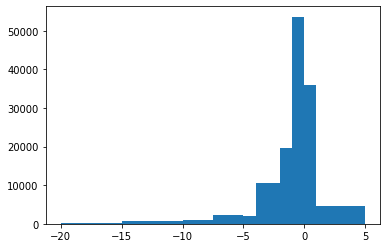

In [88]:
plt.hist(dev_probs, bins=[-20,-15,-10,-7.5,-5,-4,-2,-1,0,1,5])

In [ ]:
calcDF = pd.DataFrame(data=[dev_pred_proba[:,1]], index=['pred']).T
calcDF["label"] = dev.label
calcDF

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [114]:
os.system("mkdir /content/drive/MyDrive/models")
model.save("quora_rnn")
os.system("cp -r /content/quora_rnn /content/drive/MyDrive/models/quora_rnn")

INFO:tensorflow:Assets written to: quora_rnn/assets


INFO:tensorflow:Assets written to: quora_rnn/assets


0

In [94]:
dev_probs.reshape(dev_probs.shape[0])

array([-0.22698596, -0.06064034, -1.3568364 , ..., -0.62773347,
        0.04016158, -1.9593276 ], dtype=float32)

In [101]:
calcDF = pd.DataFrame(data=[dev_probs.reshape(dev_probs.shape[0]), [i[0] for i in dev_preds]], index=['pred','predlab']).T
calcDF["label"] = dev.label
# calcDF["pred"] = 10**calcDF.pred
calcDF

,pred,predlab,label
0,-0.226986,0.0,1
1,-0.060640,0.0,0
2,-1.356836,0.0,0
3,-0.865700,0.0,0
4,-2.535839,0.0,0
...,...,...,...
130608,-0.661710,0.0,0
130609,0.663470,1.0,0
130610,-0.627733,0.0,0
130611,0.040162,0.0,0


In [108]:

def frange(start, stop, step):
  i = start
  while i < stop:
    yield i
    i += step

columnNames = ['threshold', 'f1Score', 'accuracy', 'recall', 'precision']
thresholdDF = pd.DataFrame(columns=columnNames)

for i in frange(0.05,1,0.05):
  calcDF['pred2'] = np.where(calcDF['pred'] > i, 1, 0)
  f1Score = f1_score(calcDF.label, calcDF.pred2)
  accuracy = accuracy_score(calcDF.label, calcDF.pred2)
  recall = recall_score(calcDF.label, calcDF.pred2)
  precision = precision_score(calcDF.label, calcDF.pred2)
  thresholdDF = thresholdDF.append({'threshold': i, 'f1Score': f1Score, 
                                    'accuracy':accuracy, 'recall':recall, 
                                    'precision':precision}, 
                                   ignore_index=True)

thresholdDF

,threshold,f1Score,accuracy,recall,precision
0,0.05,0.333099,0.767925,0.929062,0.202927
1,0.10,0.356675,0.792639,0.921453,0.221136
2,0.15,0.386413,0.819245,0.912371,0.245112
3,0.20,0.412617,0.839610,0.903044,0.267398
4,0.25,0.428395,0.851056,0.894698,0.281619
5,0.30,0.440654,0.859141,0.889421,0.292879
6,0.35,0.451203,0.865848,0.884021,0.302902
7,0.40,0.460968,0.872118,0.876534,0.312711
8,0.45,0.470662,0.877952,0.869784,0.322620
9,0.50,0.480703,0.883794,0.862175,0.333254


In [109]:
optimumThreshold = thresholdDF.loc[thresholdDF['f1Score'].idxmax()][0]

optimumThreshold

0.8000000000000002

In [111]:
dev_final = dev.copy()
dev_final["prediction"] = calcDF.pred.apply(lambda x: int(x>optimumThreshold))
mispred = dev_final[dev_final.label != dev_final.prediction].reset_index()

for i in range(400,420):
    print(mispred.label[i], mispred.prediction[i], mispred.text[i], )

0 1 The foreskin of my penis does not comes down. The frenulum of my penis is not long. Will I be able to have sex? Will dis be a problem during intercourse?
1 0 Who wants to argue? I'm pro-life.
1 0 What can I do if I want to become anorexic, but not dangerously so, because I'm overweight?
0 1 How can individuals prove they are Jews when the Romans destroyed the Second Temple with all its geneological records in 70 A.D?
0 1 How are liberals feeling about the "Her Opponent" study that swaps the genders of Hillary Clinton and Donald Trump?
0 1 Do girls like tall black guys?
0 1 What are the best teachings of Islam that personally appeal to you as a Muslim?
1 0 Has someone actually benefited by drinking camel urine? (Arabs drink)
0 1 Russia's foreign ministry has stated: "Smart missiles should fly towards terrorists, not [Syria's] lawful government, which has spent years fighting against terrorism on its territory." Is this true? Do Syria fight terrorism? Or do they support it?
0 1 If ma

In [113]:
print('Accuracy:', accuracy_score(dev_final.label, dev_final.prediction))
print('F1 score:', f1_score(dev_final.label, dev_final.prediction))
print('Recall:', recall_score(dev_final.label, dev_final.prediction))
print('Precision:', precision_score(dev_final.label, dev_final.prediction))
print('\n Clasification report:\n', classification_report(dev_final.label, dev_final.prediction))

Accuracy: 0.9433287651305766
F1 score: 0.5962251800130918
Recall: 0.6707167403043691
Precision: 0.5366260801256874

 Clasification report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97    122465
           1       0.54      0.67      0.60      8148

    accuracy                           0.94    130613
   macro avg       0.76      0.82      0.78    130613
weighted avg       0.95      0.94      0.95    130613



In [115]:
from google.colab import files
files.download('quora_rnn') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>